# Project 2


The purpose of this project is to build a model, that will be able to distinguish between different seal calls. 

Grey Seals are known for their wide repertoire of communications which range from clapping [[1]](https://www.smithsonianmag.com/smart-news/first-scientists-film-grey-seals-clapping-show-their-strength-180974133/) to vocalisations so complex that they have been shown to imitate the sounds of vowels and other building blocks of human speech [[2]](https://www.pbs.org/wgbh/nova/article/seals-mimic-speech/).

This project will look at specific vocalisations called Rupes and Moans.

There are 3 types of rupes A, B and C are distinguished from each other based on frequency, duration and modulation.

The dataset used in this stuy comes froma  study into the vocalisations of grey seals off of malin head. [[3]](https://www.mdpi.com/2077-1312/12/1/118)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal
from scipy.io import wavfile
import os
from matplotlib.colors import LogNorm 

c:\Users\kolea\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#File index
file =  'data\project2\Samples Grey Seal Data\Rupes A and B\\5713.210809120002'  #from PPT at time 892-896 (Rupe B)
#file = 'Guttural rupe\\5711.211013040024'
#file = 'Rupes A and B\\5713.210825190002'
#file =          'Moan\\5713.210902110002'  #from PPT at time 212 seconds

#Read the 2 files
sample_rate, samples = wavfile.read(file+'.wav')
annot_file_path = file +'.Table.1.selections.txt'

#Read the file into a DataFrame
df = pd.read_csv(file +'.Table.1.selections.txt', sep='\t')

#Display the first few rows of the DataFrame
print(df.head())

   Selection           View  Channel  Begin Time (s)  End Time (s)  \
0          1  Spectrogram 1        1      871.984579    872.045877   
1          2  Spectrogram 1        1      872.605082    872.730809   
2          3  Spectrogram 1        1      873.525329    873.616653   
3          4  Spectrogram 1        1      874.776471    874.904325   
4          5  Spectrogram 1        1      876.693356    876.876005   

   Low Freq (Hz)  High Freq (Hz)  Delta Time (s)  Delta Freq (Hz)  \
0         75.224         426.862          0.0613          351.638   
1         42.314         470.151          0.1257          427.837   
2         65.821         493.658          0.0913          427.837   
3         70.523         441.942          0.1279          371.419   
4         47.015         413.733          0.1826          366.718   

   Avg Power Density (dB FS/Hz) Annotation  
0                        -97.26     Rupe A  
1                        -84.86     Rupe A  
2                        -90.

In [4]:
# combine all rupe call annotation into one dataframe

folder = "data\project2\Samples Grey Seal Data\Rupes A and B"

combined_df = pd.DataFrame()

for file in os.listdir(folder):
  if file.endswith('.txt'): # only want the annotated files
    file_path = os.path.join(folder, file)

    # add to dataframe
    df = pd.read_csv(file_path, sep='\t')

    combined_df = pd.concat([combined_df, df], ignore_index=True)

combined_df.head(20)

#save to CSV
combined_df.to_csv('data/project2/combined_rupes_data.csv', index=False)

## Calculate the Spectrogram

In [5]:
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate, nperseg=2456, nfft=4096, noverlap=1228, window='hann')       #Try nfft=8192 if computer permits

In [10]:
spectrogram[spectrogram < 0.001] = 0.001    #Trim off all the tiny values so that log scale displays correctly

#Trim in frequency all seal sounds are under 1000 Hz
fmin = 20 # Hz
fmax = 1000 # Hz
freq_slice = np.where((frequencies >= fmin) & (frequencies <= fmax))

#keep only frequencies of interest
frequencies = frequencies[freq_slice]
spectrogram = spectrogram[freq_slice,:][0]

In [11]:
def overlay_annotations(ax, df, annotation_colors):
    #Track labels to ensure they are added only once in the legend
    added_labels = set()

    for _, row in df.iterrows():
        start_time = row['Begin Time (s)']
        end_time = row['End Time (s)']
        low_freq = row['Low Freq (Hz)']
        high_freq = row['High Freq (Hz)']
        annotation = row['Annotation']

        #Skip if the annotation is not in the defined colors
        if annotation not in annotation_colors:
            continue

        #Draw rectangles
        ax.add_patch(
            plt.Rectangle(
                (start_time, low_freq),  #Bottom Left corner
                end_time - start_time,  #Width (time)
                high_freq - low_freq,  #Height (frequency)
                edgecolor=annotation_colors[annotation],
                facecolor='none',
                linewidth=2,
                label=annotation if annotation not in added_labels else None  #Add label once
            )
        )
        added_labels.add(annotation)  #Mark label as added

    ax.legend(loc='upper right')     #Add legend

In [12]:
def update_colormap(event):
    #Get current view limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    #Find indices corresponding to the current view limits
    x_indices = np.where((times >= xlim[0]) & (times <= xlim[1]))[0]
    y_indices = np.where((frequencies >= ylim[0]) & (frequencies <= ylim[1]))[0]

    #Handle cases where no data is visible
    if len(x_indices) == 0 or len(y_indices) == 0:
        return

    #Extract the visible data
    data_visible = spectrogram[np.ix_(y_indices, x_indices)]
    #data_visible = np.log(spectrogram)[np.ix_(y_indices, x_indices)]

    #Compute new color limits
    vmin = np.nanmin(data_visible)
    vmax = np.nanmax(data_visible)

    #Update the color limits of the pcolormesh
    pc.set_clim(vmin=vmin, vmax=vmax)
    
    #Update the colorbar to reflect the new color limits
    cbar.update_normal(pc)

    #Redraw the figure
    plt.draw()
    

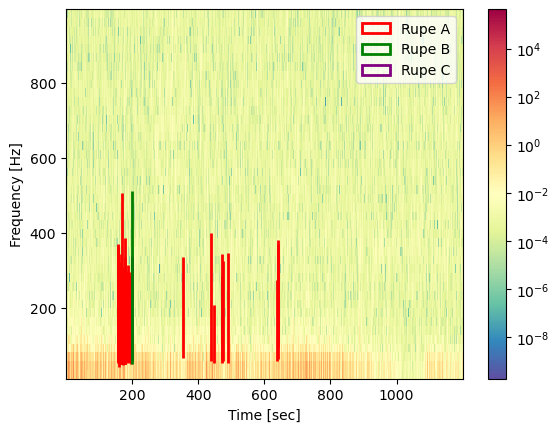

In [9]:
#Define colors for annotations
annotation_colors = {
    "Rupe A": "red",
    "Rupe B": "green",
    "Growl B": "yellow",
    "Rupe C" : "purple",
    "Moan": "pink",
    "G rupe" : "blue"
}

pc = plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
#pc = plt.pcolormesh(times, frequencies, np.log(spectrogram))
cbar = plt.colorbar(pc)
#plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

#Get the current axes
ax = plt.gca()
overlay_annotations(ax, df, annotation_colors)

#Connect the update function to the axes limit change events
ax.callbacks.connect('xlim_changed', update_colormap)
ax.callbacks.connect('ylim_changed', update_colormap)

plt.show()

(25, 469)


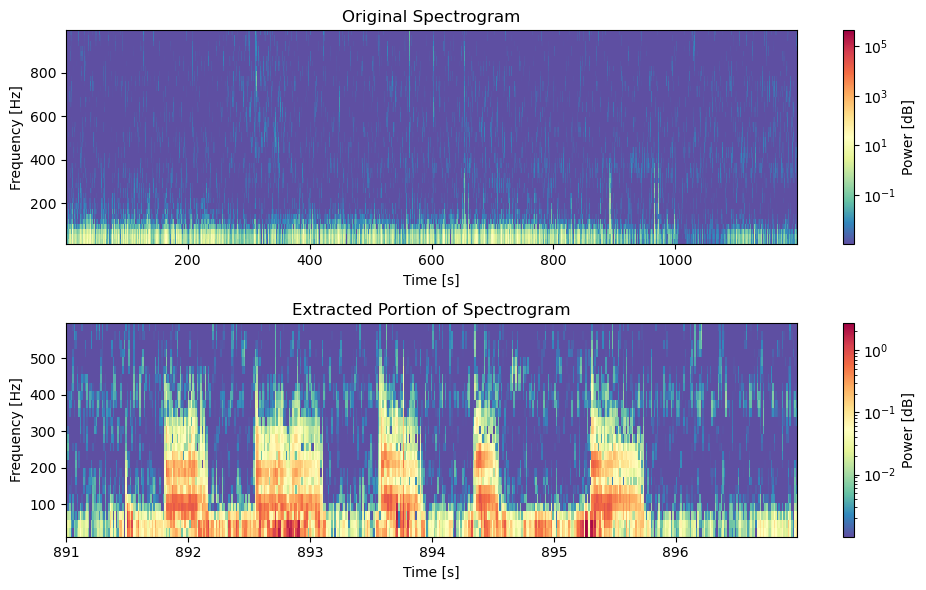

In [13]:
#Define time and frequency limits
time_start, time_end = 891, 897  # Time range in seconds
freq_start, freq_end = 20, 600  # Frequency range in Hz

#Find indices for the time range
time_indices = np.where((times >= time_start) & (times <= time_end))[0]

#Find indices for the frequency range
freq_indices = np.where((frequencies >= freq_start) & (frequencies <= freq_end))[0]

#Extract the portion of the spectrogram
spectrogram_sub = spectrogram[freq_indices][:, time_indices]
frequencies_sub = frequencies[freq_indices]
times_sub = times[time_indices]
print(spectrogram_sub.shape)

#Plot the original and sub-portion spectrograms
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
plt.title('Original Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.subplot(2, 1, 2)
plt.pcolormesh(times_sub, frequencies_sub, spectrogram_sub, norm=LogNorm(), cmap='Spectral_r')
plt.title('Extracted Portion of Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.tight_layout()
plt.show()

Spectrogram size:  (25, 55)


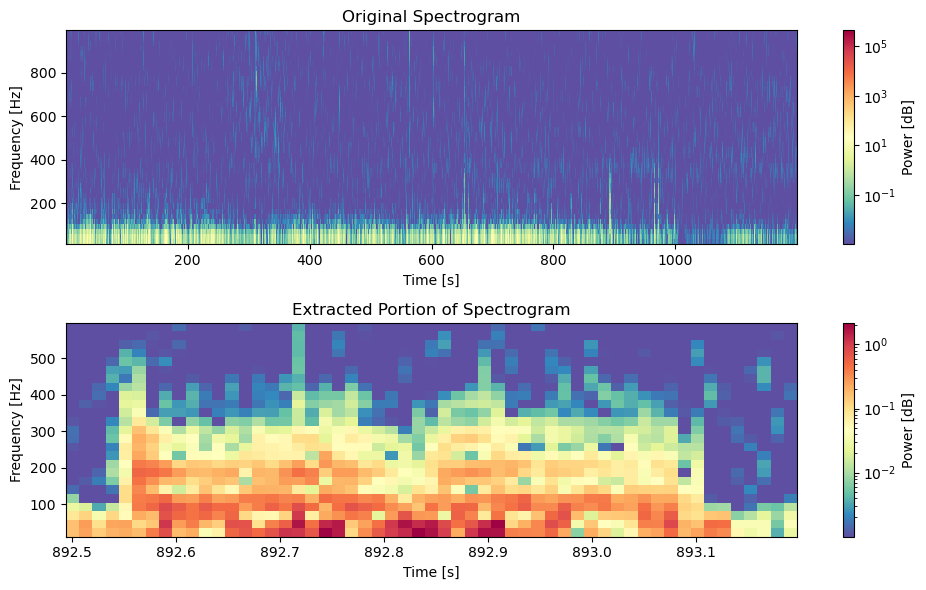

In [14]:
#Define time and frequency limits
time_start, time_end = 892.5, 893.2  # Time range in seconds
freq_start, freq_end = 20, 600  # Frequency range in Hz

#Find indices for the time range
time_indices = np.where((times >= time_start) & (times <= time_end))[0]

#Find indices for the frequency range
freq_indices = np.where((frequencies >= freq_start) & (frequencies <= freq_end))[0]

#Extract the portion of the spectrogram
spectrogram_sub = spectrogram[freq_indices][:, time_indices]
frequencies_sub = frequencies[freq_indices]
times_sub = times[time_indices]
print("Spectrogram size: ", spectrogram_sub.shape)

#Plot the original and sub-portion spectrograms
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
plt.title('Original Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.subplot(2, 1, 2)
plt.pcolormesh(times_sub, frequencies_sub, spectrogram_sub, norm=LogNorm(), cmap='Spectral_r')
plt.title('Extracted Portion of Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.tight_layout()
plt.show()

In [15]:
plt.savefig('spectrogram.png')
#plt.clf()
print(spectrogram_sub)

[[0.16207446 0.24776596 0.1362257  ... 0.0376116  0.00364482 0.02580514]
 [0.16026706 0.26273516 0.09804009 ... 0.03795517 0.00569286 0.04049847]
 [0.08340926 0.12152962 0.03355524 ... 0.02268031 0.00826415 0.03017188]
 ...
 [0.001      0.001      0.001      ... 0.001      0.001      0.001     ]
 [0.001      0.001      0.001      ... 0.001      0.00109778 0.001     ]
 [0.001      0.001      0.001      ... 0.001      0.001      0.001     ]]


<Figure size 640x480 with 0 Axes>

## References

- 1 https://www.smithsonianmag.com/smart-news/first-scientists-film-grey-seals-clapping-show-their-strength-180974133/
- 2 https://www.pbs.org/wgbh/nova/article/seals-mimic-speech/
- 3 https://www.mdpi.com/2077-1312/12/1/118
- https://towardsdatascience.com/audio-deep-learning-made-simple-part-1-state-of-the-art-techniques-da1d3dff2504
- https://medium.com/@okezieowen/audio-deep-learning-in-plain-english-b52843deb64e